## This Notebook is structured into the following sections

Section 1: A classification model to predict the product category
This model consists of two parts: 
`a.` train
and 
`b.` predict

Section 2: A model to predict the customer ratings
This model consists of two parts: 
`a.` train
and 
`b.` predict

Section 3: An engine that recommends top 5 products (i.e. product_id) to the customers in the `test` dataset
This model consists of two parts: 
`a.` train
and 
`b.` predict

Section 4: Data Analytics 
This section presents insights found in the dataset

The .config folder includes a requirements.txt file to run all code including analytics on a local machine

## Deployment
The .build folder includes python files to train and predict the data separately. The training files save the model and pipeline while the predict files load the model/pipeline and predict the labels. The datasets `dataset_en_train.json` and `dataset_en_test.json` are included for convenience.

A `requirements.txt` file is included deploy the machine learning and prediction models, excluding the dependencies required for analytics.

An environment `environment.tar.gz` to deploy on spark is provided on Dropbox.
https://www.dropbox.com/s/acgmy4zckj3q5rm/environment.tar.gz?dl=0

The application can be submitted by using spark-submit --archives environment.tar.gz --files dataset_en_train.json train_predict.py




### Section 1A Product category train

In [1]:
# Imports
import sparknlp

from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import concat,col

# Start sparknlp
spark = sparknlp.start()

print("Spark NLP version, expecting 4.3.1:  ", sparknlp.version())
print("Apache Spark version, expecting 3.2.3:  ", spark.version)

# Load dataset
train = spark.read.json("dataset_en_train.json")

# Samples per class for rebalancing
class_samples = 5000

# Resample each class to the size of the class samples with replacement
train_resampled_s = []
for c in train.select("product_category").distinct().collect():
    classDF = train.filter(train["product_category"] == c[0])
    train_resampled = classDF.sample(True, class_samples / classDF.count(), seed=42)
    train_resampled_s.append(train_resampled)

# Concatenate the resampled DataFrames
train_balanced = train_resampled_s[0]
for df in train_resampled_s[1:]:
    train_balanced = train_balanced.union(df)

# Build pipeline
document_assembler = DocumentAssembler() \
      .setInputCol("review_body") \
      .setOutputCol("document")
    
tokenizer = Tokenizer() \
      .setInputCols(["document"]) \
      .setOutputCol("token")
      
normalizer = Normalizer() \
      .setInputCols(["token"]) \
      .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

stemmer = Stemmer() \
      .setInputCols(["cleanTokens"]) \
      .setOutputCol("stem")

finisher = Finisher() \
      .setInputCols(["stem"]) \
      .setOutputCols(["token_features"]) \
      .setOutputAsArray(True) \
      .setCleanAnnotations(False)

countVectors = CountVectorizer(inputCol="token_features", outputCol="features", vocabSize=10000, minDF=5)
label_stringIdx = StringIndexer(inputCol = "product_category", outputCol = "label")

nlp_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            stemmer, 
            finisher,
            countVectors,
            label_stringIdx])

# Fit pipeline
nlp_model = nlp_pipeline.fit(train_balanced)
train_processed = nlp_model.transform(train_balanced)

# Save fitted pipeline
nlp_model.write().overwrite().save("fitted_pipeline_category")

# Classifier
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(train_processed)

# Save model
lrModel.write().overwrite().save("lrmodel_category")

Spark NLP version, expecting 4.3.1:   4.3.1
Apache Spark version, expecting 3.2.3:   3.2.3


### Section 1B Product category train

In [2]:
# Imports
import sparknlp

from sparknlp.base import *
#from sparknlp.common import *
#from sparknlp.annotator import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#from pyspark.sql.functions import concat,col

# Start sparknlp
spark = sparknlp.start()

# Load dataset
test = spark.read.json("dataset_en_test.json")

# Load PipelineModel
nlp_model = PipelineModel.load("fitted_pipeline_category")

# Load LogisticRegressionModel
lrModel = LogisticRegressionModel.load("lrmodel_category")

# Transform test data
test_processed = nlp_model.transform(test)

# predict test data
predictions = lrModel.transform(test_processed)

# Show test data
#predictions.filter(predictions['prediction'] == 0) \
#    .select("product_category","probability","label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 30)

# Evaluate test data
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(predictions))

+----------------+------------------------------+-----+----------+
|product_category|                   probability|label|prediction|
+----------------+------------------------------+-----+----------+
|         grocery|[0.9097008320795131,0.00258...|  0.0|       0.0|
|         grocery|[0.9039782737143471,0.00233...|  0.0|       0.0|
|         kitchen|[0.8434845370142527,0.00384...| 15.0|       0.0|
|         grocery|[0.8066313254284952,0.00527...|  0.0|       0.0|
|         grocery|[0.7039215708279097,0.00713...|  0.0|       0.0|
|         grocery|[0.6806057564033603,0.00364...|  0.0|       0.0|
|         grocery|[0.6179488302940529,0.00483...|  0.0|       0.0|
|         grocery|[0.601616216163087,0.013849...|  0.0|       0.0|
|           other|[0.582674077413429,0.038993...| 26.0|       0.0|
|         grocery|[0.5713643030678055,0.01404...|  0.0|       0.0|
+----------------+------------------------------+-----+----------+
only showing top 10 rows

0.43116192109904516


In [3]:
import pandas as pd
df_product_category = predictions.toPandas()

### Section 2A Product rating train

In [4]:
# Imports
import sparknlp

from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import concat,col

# Start sparknlp
spark = sparknlp.start()

print("Spark NLP version, expecting 4.3.1:  ", sparknlp.version())
print("Apache Spark version, expecting 3.2.3:  ", spark.version)

# Load dataset
train = spark.read.json("dataset_en_train.json")

# Samples per class for rebalancing
class_samples = 5000

# Resample each class to the size of the class samples with replacement
train_resampled_s = []
for c in train.select("product_category").distinct().collect():
    classDF = train.filter(train["product_category"] == c[0])
    train_resampled = classDF.sample(True, class_samples / classDF.count(), seed=42)
    train_resampled_s.append(train_resampled)

# Concatenate the resampled DataFrames
train_balanced = train_resampled_s[0]
for df in train_resampled_s[1:]:
    train_balanced = train_balanced.union(df)

# Build pipeline
document_assembler = DocumentAssembler() \
      .setInputCol("review_body") \
      .setOutputCol("document")
    
tokenizer = Tokenizer() \
      .setInputCols(["document"]) \
      .setOutputCol("token")
      
normalizer = Normalizer() \
      .setInputCols(["token"]) \
      .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

stemmer = Stemmer() \
      .setInputCols(["cleanTokens"]) \
      .setOutputCol("stem")

finisher = Finisher() \
      .setInputCols(["stem"]) \
      .setOutputCols(["token_features"]) \
      .setOutputAsArray(True) \
      .setCleanAnnotations(False)

countVectors = CountVectorizer(inputCol="token_features", outputCol="features", vocabSize=10000, minDF=5)
label_stringIdx = StringIndexer(inputCol = "stars", outputCol = "label")

nlp_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            stemmer, 
            finisher,
            countVectors,
            label_stringIdx])

# Concat review_title and review_body columns
train_rating = train.withColumn("review_body", concat(train.review_title, train.review_body))

# Fit pipeline
nlp_model = nlp_pipeline.fit(train_rating)
train_processed = nlp_model.transform(train_rating)

# Save fitted pipeline
nlp_model.write().overwrite().save("fitted_pipeline_rating")

# Classifier
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(train_processed)

# Save model
lrModel.write().overwrite().save("lrmodel_rating")

Spark NLP version, expecting 4.3.1:   4.3.1
Apache Spark version, expecting 3.2.3:   3.2.3


### Section 2B Product rating predict

In [5]:
# Imports
import sparknlp

from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import concat,col

# Start sparknlp
spark = sparknlp.start()

# Load dataset
test = spark.read.json("dataset_en_test.json")

# Load PipelineModel
nlp_model = PipelineModel.load("fitted_pipeline_rating")

# Load LogisticRegressionModel
lrModel = LogisticRegressionModel.load("lrmodel_rating")

# Concat review_title and review_body
test_rating = test.withColumn("review_body", concat(test.review_title, test.review_body))

# Transform test data
test_processed = nlp_model.transform(test_rating)

# predict test data
predictions = lrModel.transform(test_processed)

# Show test data
#predictions.filter(predictions['prediction'] == 0) \
#    .select("review_body","stars","probability","label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 30)

# Evaluate test data
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(predictions))

0.5394661580603644


In [7]:
import pandas as pd
df_product_rating = predictions.toPandas()

### Section 3A Recommendation system train

In [8]:
# Imports
import sparknlp

from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import concat,col

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql import Row

# Start sparknlp
spark = sparknlp.start()

print("Spark NLP version, expecting 4.3.1:  ", sparknlp.version())
print("Apache Spark version, expecting 3.2.3:  ", spark.version)

# Load dataset
train = spark.read.json("dataset_en_train.json")

# Fit pipeline
stringIndexer = StringIndexer(inputCol="product_id", outputCol="product_id_int")
nlp_model = stringIndexer.fit(train)
train_processed = nlp_model.transform(train)

stringIndexer = StringIndexer(inputCol="reviewer_id", outputCol="reviewer_id_int")
nlp_model = stringIndexer.fit(train_processed)
train_processed = nlp_model.transform(train_processed)

train_processed = train_processed.withColumn("stars", col("stars").cast("int"))

als = ALS(maxIter=5, regParam=0.01, userCol="reviewer_id_int", itemCol="product_id_int", ratingCol="stars",
          coldStartStrategy="drop")
model = als.fit(train_processed)

# Save model
model.write().overwrite().save("alsmodel_recommendation")

Spark NLP version, expecting 4.3.1:   4.3.1
Apache Spark version, expecting 3.2.3:   3.2.3


### Section 3B Recommendation system predict

In [ ]:
# Imports
import sparknlp

from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import concat,col

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql import Row

# Start sparknlp
spark = sparknlp.start()

# Load dataset
test = spark.read.json("dataset_en_test.json")

stringIndexer = StringIndexer(inputCol="product_id", outputCol="product_id_int")
nlp_model = stringIndexer.fit(test)
test_processed = nlp_model.transform(test)

stringIndexer = StringIndexer(inputCol="reviewer_id", outputCol="reviewer_id_int")
nlp_model = stringIndexer.fit(test_processed)
test_processed = nlp_model.transform(test_processed)

test_processed = test_processed.withColumn("stars", col("stars").cast("int"))

#test_processed.groupBy('product_id_int').count().orderBy('count', ascending=False).show(10)

# Load ALSModel
model = ALSModel.load("alsmodel_recommendation")

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test_processed)

# Recommend 5 products for all reviewers
userRecs = model.recommendForAllUsers(5)
#userRecs.show()

In [10]:
import pandas as pd
df_product_recommendation = userRecs.toPandas()

### Section 4: Data Analytics
Insights that were found from the provided dataset as well as the predictive results

In [11]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

#pdf = predictions_.toPandas()
filtered_df = df_product_category.drop_duplicates(subset=['product_category'])
filtered_df = filtered_df.sort_values(by=['label'])

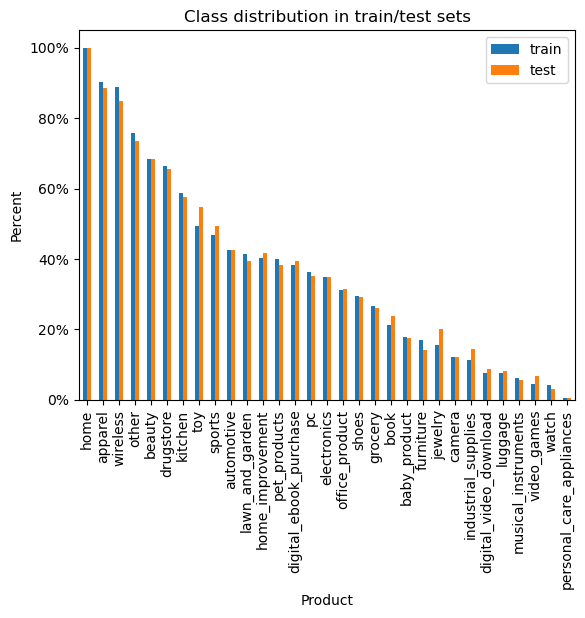

In [12]:
import matplotlib.ticker as mtick

# Load dataset
df_train = train.toPandas()

train_test = pd.concat([df_train['product_category'].value_counts().to_frame('train'), df_product_category['product_category'].value_counts().to_frame('test')], axis=1)
train_test['train'] = 100*train_test['train']/train_test['train'].max()
train_test['test'] = 100*train_test['test']/train_test['test'].max()

ax = train_test.plot(kind='bar')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Class distribution in train/test sets')
plt.xlabel('Product')
plt.ylabel('Percent')
plt.show()

The classes in the training and test dataset are highly imbalanced, however they follow a similar distribution

The classes in the training and test dataset are highly imbalanced, however they follow a similar distribution

                          precision    recall  f1-score   support

                 grocery       0.37      0.74      0.49       115
                    book       0.33      0.44      0.37       105
                   watch       0.15      0.85      0.26        13
personal_care_appliances       0.00      0.00      0.00         2
             video_games       0.18      0.50      0.27        30
     musical_instruments       0.12      0.32      0.17        25
                 luggage       0.16      0.58      0.25        36
  digital_video_download       0.36      0.71      0.48        38
          office_product       0.31      0.32      0.31       139
               drugstore       0.46      0.31      0.37       289
     industrial_supplies       0.05      0.12      0.07        64
               furniture       0.26      0.61      0.36        62
            baby_product       0.32      0.35      0.34        77
                   shoes       0.48      0.62      0.54       129
         

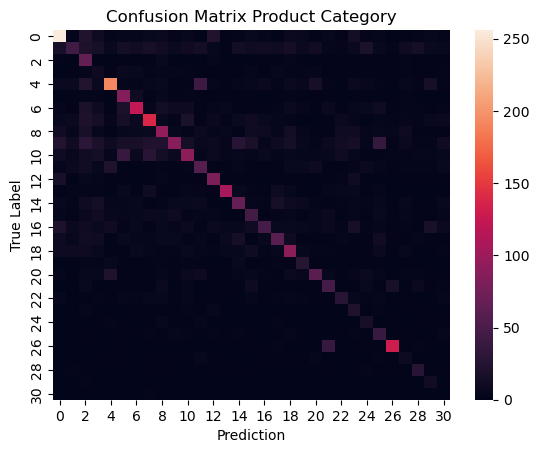

In [13]:
# Print classification report
print(classification_report(df_product_category['label'], df_product_category['prediction'], target_names=filtered_df['product_category'].tolist()))

# Create the confusion matrix
labels = df_product_category['label'].unique()
conf_mat = confusion_matrix(df_product_category['label'], df_product_category['prediction'], labels=labels)

# Create a heatmap of the confusion matrix
ax = plt.subplot()
sns.heatmap(conf_mat, fmt='g', ax=ax)

# Set the axis labels
ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

# Set the title
ax.set_title('Confusion Matrix Product Category')

# Show the plot
plt.show()


The product classifier achieves an f-1 score of 0.43 for all classes on a balanced dataset. For this dataset, the accuracy decreased due to upsampling the minority classes. However, this is still expected to be the right design choice as the classifier would only predict the majority classes on the unbalanced dataset, therefore not scaling well for big data.

              precision    recall  f1-score   support

         0.0       0.61      0.71      0.66      1000
         1.0       0.49      0.41      0.44      1000
         2.0       0.49      0.41      0.44      1000
         3.0       0.54      0.45      0.49      1000
         4.0       0.58      0.77      0.66      1000

    accuracy                           0.55      5000
   macro avg       0.54      0.55      0.54      5000
weighted avg       0.54      0.55      0.54      5000



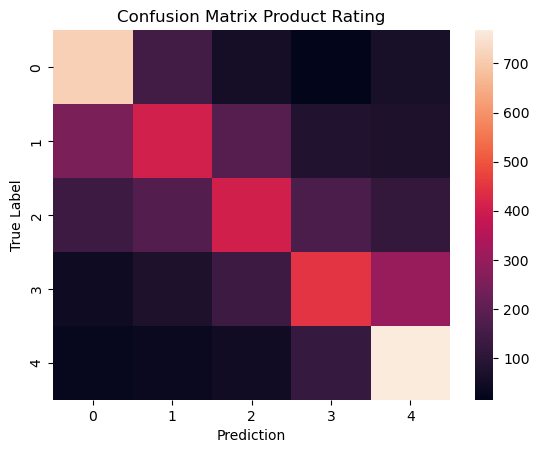

In [14]:
# Print classification report
print(classification_report(df_product_rating['label'], df_product_rating['prediction']))

# Create the confusion matrix
conf_mat = confusion_matrix(df_product_rating['label'], df_product_rating['prediction'])

# Create a heatmap of the confusion matrix
ax = plt.subplot()
sns.heatmap(conf_mat, fmt='g', ax=ax)

# Set the axis labels
ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

# Set the title
ax.set_title('Confusion Matrix Product Rating')

# Show the plot
plt.show()

The product rating classifier achieves and f1-score of 0.54. The prediction is symmetric about the diagonal and similar to human grading, the extreme values 0 and 5 stars show the highest accuracy.

In [15]:
df_product_recommendation.head()

,reviewer_id_int,recommendations
0,28,"[(876, 6.865847587585449), (1259, 6.4914388656..."
1,31,"[(2217, 6.171055793762207), (5619, 5.785284042..."
2,34,"[(1052, 6.880202293395996), (8880, 6.096117496..."
3,53,"[(6644, 6.060212135314941), (974, 5.8679122924..."
4,65,"[(9964, 6.997037887573242), (741, 6.7538666725..."


<AxesSubplot: ylabel='Frequency'>

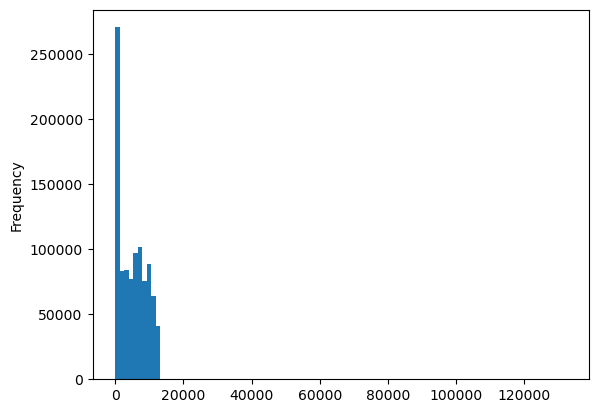

In [16]:
df_product_rec_exp = df_product_recommendation.explode('recommendations')
df_product_rec_exp = df_product_rec_exp.explode('recommendations')
df_product_rec_exp = df_product_rec_exp.iloc[::2, :]
df_product_rec_exp['recommendations'].plot.hist(bins=100)

The following plot shows the product_id distribution of the top5 recommended products for the test dataset, where the x-axis is the numerical product id

In [17]:
from pyspark.sql.functions import col
test.groupBy("product_category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(40)

+--------------------+-----+
|    product_category|count|
+--------------------+-----+
|                home|  440|
|             apparel|  390|
|            wireless|  374|
|               other|  324|
|              beauty|  301|
|           drugstore|  289|
|             kitchen|  254|
|                 toy|  241|
|              sports|  217|
|          automotive|  187|
|    home_improvement|  183|
|digital_ebook_pur...|  173|
|     lawn_and_garden|  173|
|        pet_products|  168|
|                  pc|  155|
|         electronics|  153|
|      office_product|  139|
|               shoes|  129|
|             grocery|  115|
|                book|  105|
|             jewelry|   89|
|        baby_product|   77|
| industrial_supplies|   64|
|           furniture|   62|
|              camera|   54|
|digital_video_dow...|   38|
|             luggage|   36|
|         video_games|   30|
| musical_instruments|   25|
|               watch|   13|
|personal_care_app...|    2|
+-------------